In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.6.0


In [3]:
print("Pandas version: ", pd.__version__)
signs = pd.read_csv('Images/traffic-signs/Train.csv')
signs.head()

Pandas version:  1.3.4


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
data_dir = pathlib.Path('Images/traffic-signs/Train')
data_dir

WindowsPath('Images/traffic-signs/Train')

In [5]:
img_height = 28
img_width = 28
batch_size = 32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

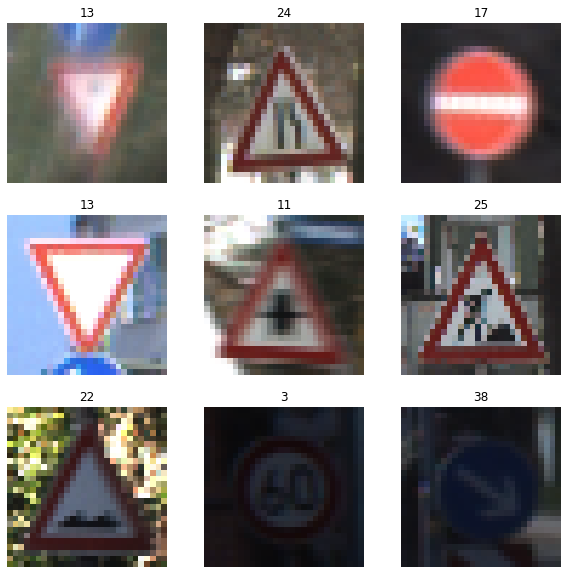

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch[0])
    break

(32, 28, 28, 3)
(32,)
tf.Tensor(27, shape=(), dtype=int32)


In [11]:
for batch in train_ds:
    print(type(batch))
    break

<class 'tuple'>


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
print(f"image batch shape: {image_batch.shape}")
print(f"labels batch shape: {labels_batch.shape}")
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(f"min: {np.min(first_image)}; max: {np.max(first_image)};")

image batch shape: (32, 28, 28, 3)
labels batch shape: (32,)
min: 0.07866396754980087; max: 0.47416096925735474;


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 43

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # transforms format from 2d array to 1d array:
    tf.keras.layers.Flatten(),
    # 2 fully connected layers:
    tf.keras.layers.Dense(128, activation='relu'),
    # returns logits array with length 43 (labels)
    tf.keras.layers.Dense(num_classes)
])
#, kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
981/981 [==============================] - 20s 20ms/step - loss: 1.0611 - accuracy: 0.7298 - val_loss: 0.3344 - val_accuracy: 0.9260
Epoch 2/3
981/981 [==============================] - 13s 13ms/step - loss: 0.2411 - accuracy: 0.9416 - val_loss: 0.1999 - val_accuracy: 0.9517
Epoch 3/3
981/981 [==============================] - 13s 13ms/step - loss: 0.1368 - accuracy: 0.9682 - val_loss: 0.1594 - val_accuracy: 0.9635


## Make model that shows probabilities

In [18]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [19]:
import matplotlib.pyplot as plt

In [20]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [21]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(43))
    plt.yticks([])
    thisplot = plt.bar(range(43), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    plt.title(str(f"True:{class_names[true_label.numpy()]}; Pred: {class_names[predicted_label]}"))

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

## Evaluating model with test data

In [22]:
test_table = pd.read_csv('Images/traffic-signs/Test.csv')
test_labels = test_table['ClassId'].to_numpy()
test_labels_tuple = tuple(test_labels)

In [23]:
test_dir = pathlib.Path('Images/traffic-signs/Test')

#### Make sure the dataset Directory has a proper structure

Test data has been organised with the pythonscript 'Organize Testdata Trafficsigns.ipynb'

In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 12630 files belonging to 43 classes.


In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy = {test_acc} \nLoss = {test_loss}")

395/395 [==============================] - 4s 9ms/step - loss: 0.4835 - accuracy: 0.8983
Accuracy = 0.8982580900192261 
Loss = 0.4835495948791504


## Making predictions on test data

### Calculate accuracy manualy

In [26]:
pred_model = model.predict(test_ds)

In [27]:
np_test_labels = np.array([])
for images, labels in test_ds:
    np_test_labels = np.append(np_test_labels, labels.numpy())
np_test_labels.shape

(12630,)

In [28]:
# sum([ np.argmax(pred_model[i]) == np_test_labels[i] for i in range(len(np_test_labels))]) / len(np_test_labels)

### Using the Probability model

In [29]:
test_images, test_labels = next(iter(test_ds))
print(test_images.shape)
print(test_labels.shape)

(32, 28, 28, 3)
(32,)


In [30]:
predictions = prob_model.predict(test_images)

In [31]:
predictions.shape

(32, 43)

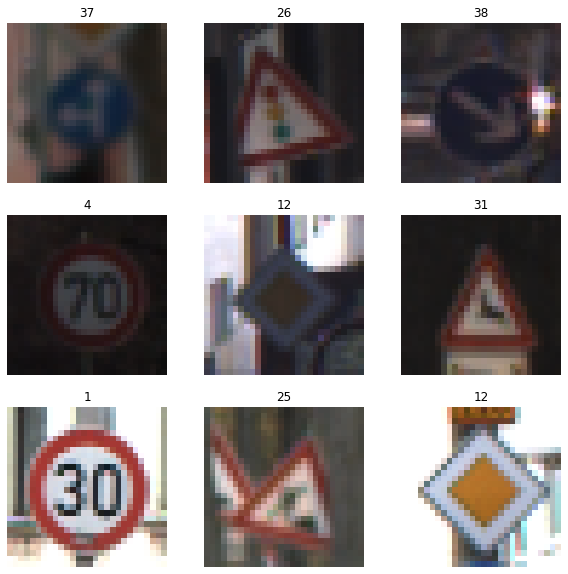

In [32]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(class_names[test_labels[i]])
    plt.axis("off")

In [33]:
for i in range(10):
    print(f"pred: {np.argmax(predictions[i])}; True: {test_labels[i]};")

pred: 31; True: 31;
pred: 19; True: 19;
pred: 32; True: 32;
pred: 34; True: 34;
pred: 4; True: 4;
pred: 25; True: 25;
pred: 1; True: 1;
pred: 2; True: 18;
pred: 4; True: 4;
pred: 8; True: 8;


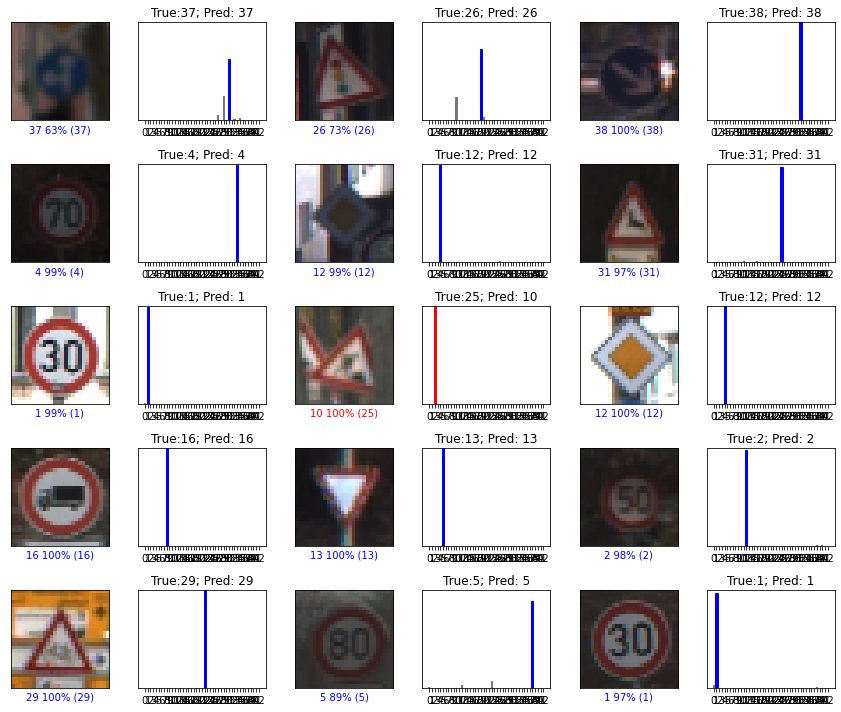

In [34]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Try and predict on image

In [35]:
image_name = 'test_bord3.JPG'
image_class_nr = 18

In [36]:
image_path = f'C:\\Users\\nickd\\.keras\\datasets\\{image_name}'

In [37]:
loaded_image = tf.keras.preprocessing.image.load_img(
    image_path, 
    target_size=(img_height, img_width)
)

In [38]:
img = tf.keras.preprocessing.image.img_to_array(loaded_image)
img_arr = np.expand_dims(img, 0)
# img_arr = img_arr / 255
print(f"min: {np.min(img_arr)}; max: {np.max(img_arr)};")
img_arr.shape

min: 0.0; max: 255.0;


(1, 28, 28, 3)

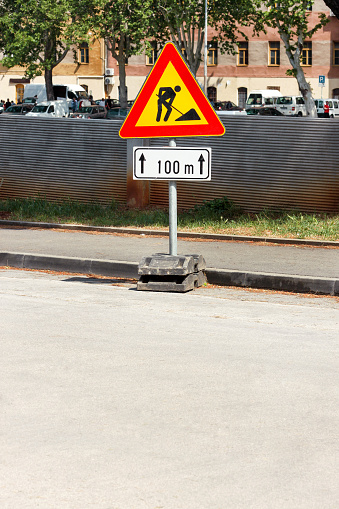

In [39]:
import PIL
img_dir = pathlib.Path(f'C:/Users/nickd/.keras/datasets/{image_name}')
# img_arr_reshapen = img_arr.reshape(1,28,28)
# img_arr_reshapen.shape
# img = img.reshape(28,28)
PIL.Image.open(img_dir)
# afbeeldingske = PIL.Image.open(loaded_image)
# afbeeldingske.show()

In [40]:
single_pred = prob_model.predict(img_arr)
single_pred[0]

array([2.6527830e-11, 1.6896028e-17, 1.7950873e-04, 6.4644165e-14,
       1.3126050e-10, 2.5371694e-16, 1.0264748e-16, 8.1894779e-19,
       1.8161093e-07, 1.0749874e-13, 7.8169020e-11, 1.7437403e-04,
       4.1003463e-09, 1.2568838e-03, 6.1769485e-14, 1.9733413e-18,
       2.1016058e-06, 1.0424337e-14, 1.7652827e-06, 4.1136721e-12,
       2.5813476e-14, 2.5540748e-17, 3.5945058e-10, 1.6579199e-12,
       1.6778096e-18, 2.1034287e-15, 1.9632551e-13, 1.3195939e-17,
       1.7788118e-18, 2.4689327e-15, 3.6476775e-15, 1.8449478e-13,
       3.0436935e-15, 3.7662743e-19, 1.8645584e-15, 7.8609279e-16,
       1.0021182e-03, 1.4422255e-13, 7.4126157e-12, 2.1495010e-16,
       2.1010737e-20, 8.8648960e-29, 9.9738306e-01], dtype=float32)

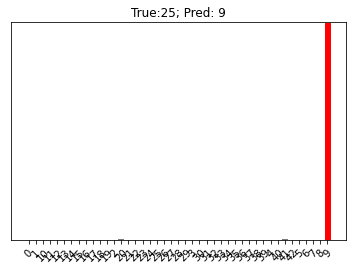

In [41]:
import matplotlib.pyplot as plt
plot_value_array(0, single_pred[0], tf.constant([image_class_nr])) # Op positie 10 staat de waarde '18'
_ = plt.xticks(range(num_classes), class_names, rotation=45)
plt.show()

In [42]:
print(f"It is {single_pred[0][np.argmax(single_pred)]} sure that it is a {class_names[np.argmax(single_pred)]}")

It is 0.9973830580711365 sure that it is a 9


In [43]:
print(f"It is {single_pred[0][test_labels[np.argmax(single_pred)]]} sure that it is a {class_names[image_class_nr]}")

InvalidArgumentError: slice index 42 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
single_pred.sum()